# Final Project COMP 551
Towards Real-World Blind Face Restoration with Generative Facial Prior <br>
https://arxiv.org/pdf/2101.04061.pdf

#Git Clone the directory

In [ ]:
!git clone https://github.com/TencentARC/GFPGAN.git

Cloning into 'GFPGAN'...
remote: Enumerating objects: 346, done.
remote: Counting objects: 100% (211/211), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 346 (delta 101), reused 154 (delta 53), pack-reused 135
Receiving objects: 100% (346/346), 5.29 MiB | 30.96 MiB/s, done.
Resolving deltas: 100% (163/163), done.


In [ ]:
%cd GFPGAN



/content/GFPGAN/GFPGAN


In [ ]:
ls -a -l

total 116
drwxr-xr-x 11 root root  4096 Dec 13 00:36 ./
drwxr-xr-x 12 root root  4096 Dec 13 00:36 ../
drwxr-xr-x  3 root root  4096 Dec 13 00:36 experiments/
drwxr-xr-x  6 root root  4096 Dec 13 00:36 gfpgan/
drwxr-xr-x  8 root root  4096 Dec 13 00:36 .git/
drwxr-xr-x  3 root root  4096 Dec 13 00:36 .github/
-rw-r--r--  1 root root  1891 Dec 13 00:36 .gitignore
-rw-r--r--  1 root root  5273 Dec 13 00:36 inference_gfpgan.py
drwxr-xr-x  4 root root  4096 Dec 13 00:36 inputs/
-rw-r--r--  1 root root 22990 Dec 13 00:36 LICENSE
-rw-r--r--  1 root root   173 Dec 13 00:36 MANIFEST.in
drwxr-xr-x  2 root root  4096 Dec 13 00:36 options/
-rw-r--r--  1 root root  3146 Dec 13 00:36 PaperModel.md
-rw-r--r--  1 root root  1483 Dec 13 00:36 .pre-commit-config.yaml
-rw-r--r--  1 root root  7913 Dec 13 00:36 README.md
-rw-r--r--  1 root root   158 Dec 13 00:36 requirements.txt
drwxr-xr-x  2 root root  4096 Dec 13 00:36 scripts/
-rw-r--r--  1 root root   685 Dec 13 00:36 setup.cfg
-rw-r--r--  1 root ro

#Installing Dependencies

In [ ]:
%%capture
# Install basicsr - https://github.com/xinntao/BasicSR
# We use BasicSR for both training and inference
!pip install basicsr

# Install facexlib - https://github.com/xinntao/facexlib
# We use face detection and face restoration helper in the facexlib package
!pip install facexlib

!pip install -r requirements.txt
!python setup.py develop

# If you want to enhance the background (non-face) regions with Real-ESRGAN,
# you also need to install the realesrgan package
!pip install realesrgan

In [ ]:
%%capture
pip install -r requirements.txt

In [ ]:
import numpy as np
from scipy import fftpack
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import os
import cv2
from PIL import Image

# Download Pre-trained model 

In [ ]:
%%capture
# PAPER MODEL WITH COLOR
!wget https://github.com/TencentARC/GFPGAN/releases/download/v0.1.0/GFPGANv1.pth -P experiments/pretrained_models


In [ ]:
! pip install Ninja

# Helpers

In [ ]:
def display_imgs_in_folder(folder_path):
  for im_path in os.listdir(folder_path):
    img=cv2.imread(folder_path + '/' + im_path)
    img = cv2_imshow(img)

# Image Degradation Pipeline

**We will pre-process the images as done in the paper:**<br>
1- Apply gaussian blur (sigma from 0.2 to 10, kernal size unsepcified, so we use a range from 3 to 30) <br>
2- downsize image by a factor of r (from 1 to 8)<br>
3- add white gaussian noise n-delta (delta from 0 to 15)<br>
4- compress by JPEG with quality factor q (q from 60 to 100)<br>

In [ ]:
cd ~/../content/GFPGAN/

/content/GFPGAN


## 1- Guassian Blur

In [ ]:
def apply_gaussian_blur(image, size=(15,15), std=0, as_jpg=False):
  if as_jpg:
    image=cv2.imread(image)
  return cv2.GaussianBlur(image, size, std)

## 2- Resize image

In [ ]:
def resize_img(image, size,interpolation = cv2.INTER_AREA):
  return cv2.resize(image, (size, size), interpolation=interpolation)

## 3- Add white gaussian noise

In [ ]:
'''
expects image inputs to be between 0 and 1
'''
def add_gaussian_noise(image, sigma=10):
  noise = np.random.normal(size=image.shape)*sigma/255
  image += noise
  return image
  

## Putting Everything Together

In [ ]:
def process_images(in_dir, out_dir=None, normalize=True,
                   ker_size=np.arange(3,15,2), stds=np.arange(0.2,5,0.1),
                   r=np.arange(1,3,1),
                   sigmas=np.arange(0,15,1)):
  if out_dir is None:
    out_dir = in_dir
  if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
  for im_path in os.listdir(in_dir):
    image = cv2.imread(in_dir+'/'+im_path)
    image_shape = image.shape
    # # resize image to 512*512
    # image = resize_img(image, 512)
    
    if normalize:
      cv2.normalize(image, image, 0, 255, cv2.NORM_MINMAX)
    
    # apply gaussian blur
    size = np.random.choice(ker_size)
    std = np.random.choice(stds)
    image=apply_gaussian_blur(image, size=(size,size), std=std)
   
    # downscale image by a factor of r
    downscale_factor = np.random.choice(r)
    image = resize_img(image, int(512/downscale_factor))

    # add white gaussian noise
    sigma = np.random.choice(sigmas)
    image = add_gaussian_noise(image/255, sigma=sigma)

    if normalize:
      cv2.normalize(image, image, 0, 255, cv2.NORM_MINMAX)
    
    image=resize_img(image, image_shape[0])

    print(cv2_imshow(image))

    cv2.imwrite(out_dir+'/'+im_path, image)

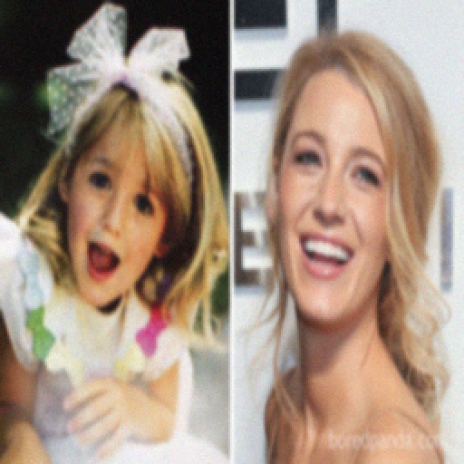

None


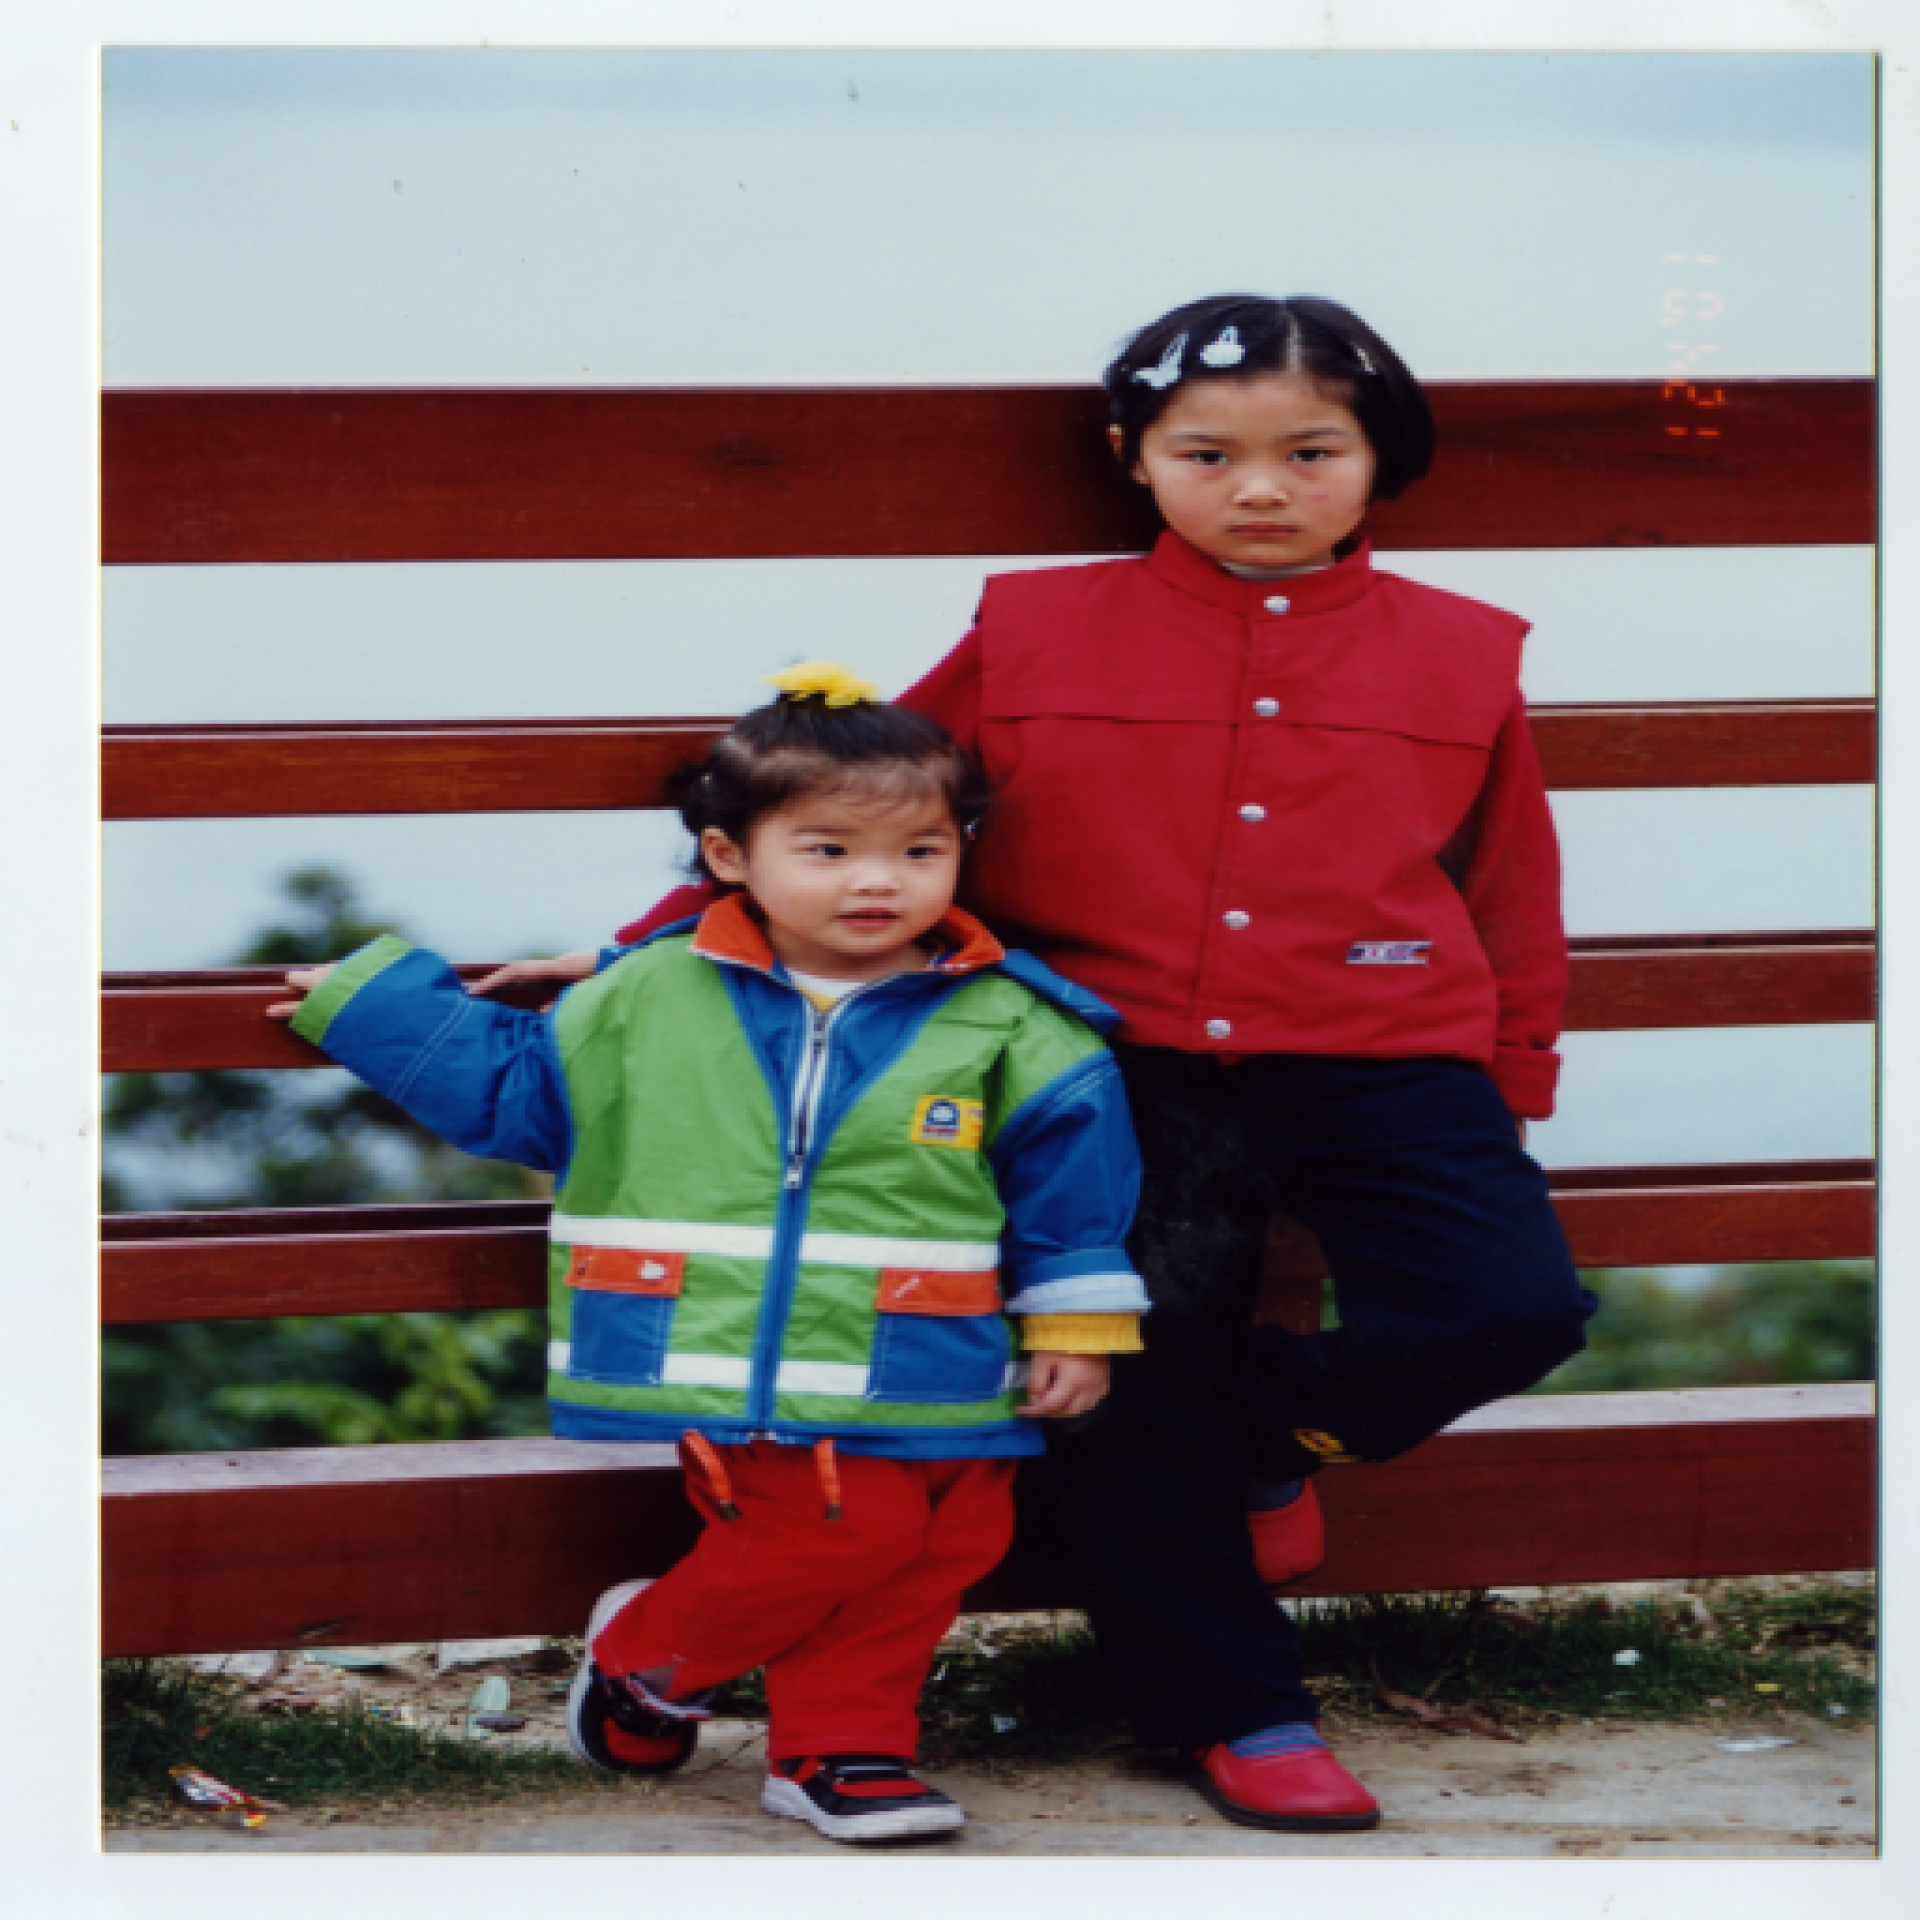

None


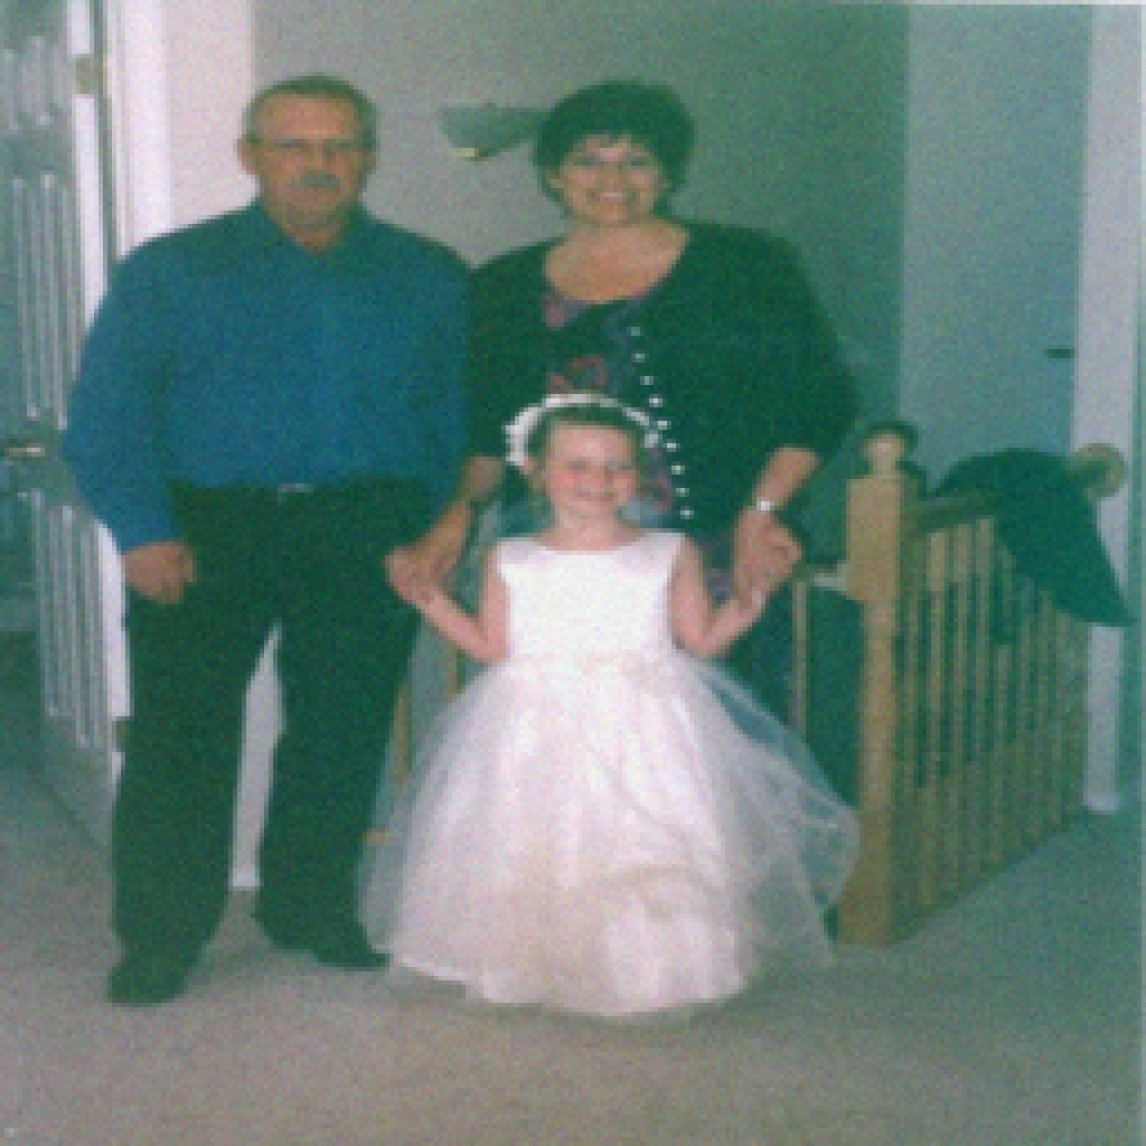

None


In [ ]:
process_images('inputs/whole_imgs', 'inputs/processed_images')

In [ ]:
!BASICSR_JIT=True python inference_gfpgan.py --model_path experiments/pretrained_models/GFPGANv1.pth --test_path inputs/processed_images --save_root results_pre_processed --arch original --channel 1

Processing 00.jpg ...
	Tile 1/25
	Tile 2/25
	Tile 3/25
	Tile 4/25
	Tile 5/25
	Tile 6/25
	Tile 7/25
	Tile 8/25
	Tile 9/25
	Tile 10/25
	Tile 11/25
	Tile 12/25
	Tile 13/25
	Tile 14/25
	Tile 15/25
	Tile 16/25
	Tile 17/25
	Tile 18/25
	Tile 19/25
	Tile 20/25
	Tile 21/25
	Tile 22/25
	Tile 23/25
	Tile 24/25
	Tile 25/25
Processing 10045.png ...
	Tile 1/9
	Tile 2/9
	Tile 3/9
	Tile 4/9
	Tile 5/9
	Tile 6/9
	Tile 7/9
	Tile 8/9
	Tile 9/9
Processing Blake_Lively.jpg ...
	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4
Results are in the [results_pre_processed] folder.


In [ ]:
display_imgs_in_folder('results_pre_processed/restored_imgs')

# Testing datasets

## MAKE DIRECTORIES

In [ ]:
cd ~/../content/GFPGAN/

/content/GFPGAN


In [ ]:
os.mkdir("inputs/celebA")

In [ ]:
os.mkdir("inputs/wider")

In [ ]:
os.mkdir("inputs/utk")

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


##CelebA Dataset


In [ ]:
cd ~/../content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/celebA/img_align_celeba/img_align_celeba


/content/drive/.shortcut-targets-by-id/1G2i3q3mlpKirBq_YaqwB7qtvERTNvDU2/Mini-Project 4 - GFPGAN/celebA/img_align_celeba/img_align_celeba


In [ ]:
!rsync -a RANDOM  ~/../content/GFPGAN/inputs/celebA

rsync: link_stat "/content/drive/.shortcut-targets-by-id/1G2i3q3mlpKirBq_YaqwB7qtvERTNvDU2/Mini-Project 4 - GFPGAN/celebA/img_align_celeba/img_align_celeba/RANDOM" failed: Input/output error (5)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1196) [sender=3.1.2]


##Wider Dataset

In [ ]:
cd ~/../content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN

/content/drive/.shortcut-targets-by-id/1G2i3q3mlpKirBq_YaqwB7qtvERTNvDU2/Mini-Project 4 - GFPGAN


In [ ]:
!rsync -a wider/RANDOM ~/../content/GFPGAN/inputs/wider

## UTK Dataset

In [ ]:
cd ~/../content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN

/content/drive/.shortcut-targets-by-id/1G2i3q3mlpKirBq_YaqwB7qtvERTNvDU2/Mini-Project 4 - GFPGAN


In [ ]:
!rsync -a part1/RANDOM ~/../content/GFPGAN/inputs/utk

# Testing the model with new datasets

In [ ]:
cd ~/../content/GFPGAN/

## celebA

In [ ]:
process_images("inputs/celebA/RANDOM", "inputs/processed_images/celebA",
                   ker_size=np.arange(3,15,2), stds=np.arange(0.2,10,0.1),
                   r=np.arange(1,8,1),
                   sigmas=np.arange(0,15,1))

In [ ]:
!BASICSR_JIT=True python inference_gfpgan.py --model_path experiments/pretrained_models/GFPGANv1.pth --test_path inputs/processed_images/celebA --save_root results_celebA --arch original --channel 1

In [ ]:
display_imgs_in_folder('results_celebA/cmp')

### Transfer the results to drive

In [ ]:
#!rsync -a results_celebA/ ~/../content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/results/celebA

## Wider

In [ ]:
process_images("inputs/wider/RANDOM", "inputs/processed_images/wider",
                   ker_size=np.arange(3,15,2), stds=np.arange(0.2,10,0.1),
                   r=np.arange(1,8,1),
                   sigmas=np.arange(0,15,1))

In [ ]:
!BASICSR_JIT=True python inference_gfpgan.py --model_path experiments/pretrained_models/GFPGANv1.pth --test_path inputs/processed_images/wider --save_root results_wider --arch original --channel 1

Processing 0_Parade_Parade_0_5.jpg ...
	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4
Processing 0_Parade_marchingband_1_56.jpg ...
	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4
Processing 0_Parade_marchingband_1_691.jpg ...
	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4
Processing 0_Parade_marchingband_1_939.jpg ...
	Tile 1/49
	Tile 2/49
	Tile 3/49
	Tile 4/49
	Tile 5/49
	Tile 6/49
	Tile 7/49
	Tile 8/49
	Tile 9/49
	Tile 10/49
	Tile 11/49
	Tile 12/49
	Tile 13/49
	Tile 14/49
	Tile 15/49
	Tile 16/49
	Tile 17/49
	Tile 18/49
	Tile 19/49
	Tile 20/49
	Tile 21/49
	Tile 22/49
	Tile 23/49
	Tile 24/49
	Tile 25/49
	Tile 26/49
	Tile 27/49
	Tile 28/49
	Tile 29/49
	Tile 30/49
	Tile 31/49
	Tile 32/49
	Tile 33/49
	Tile 34/49
	Tile 35/49
	Tile 36/49
	Tile 37/49
	Tile 38/49
	Tile 39/49
	Tile 40/49
	Tile 41/49
	Tile 42/49
	Tile 43/49
	Tile 44/49
	Tile 45/49
	Tile 46/49
	Tile 47/49
	Tile 48/49
	Tile 49/49
Processing 10_People_Marching_People_Marching_2_261.jpg ...
	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4
Processing 10_People_M

In [ ]:
display_imgs_in_folder('results_wider/cmp')

### Transfer the results to drive

In [ ]:
#!rsync -a results_wider/ ~/../content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/results/wider

## UTK

In [ ]:
process_images("inputs/utk/RANDOM", "inputs/processed_images/utk",
                   ker_size=np.arange(3,15,2), stds=np.arange(0.2,10,0.1),
                   r=np.arange(1,8,1),
                   sigmas=np.arange(0,15,1))

In [ ]:
!BASICSR_JIT=True python inference_gfpgan.py --model_path experiments/pretrained_models/GFPGANv1.pth --test_path inputs/processed_images/utk --save_root results_utk --arch original --channel 1

In [ ]:
display_imgs_in_folder('results_utk/cmp')

### Transfer the results to drive

In [ ]:
#!rsync -a results_utk/ ~/../content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/results/UTK

## Wider with less noise

In [ ]:
process_images("inputs/wider/RANDOM", "inputs/processed_images/wider_2",
                   ker_size=np.arange(3,9,2), stds=np.arange(0.2,5,0.1),
                   r=np.arange(1,3,1),
                   sigmas=np.arange(0,12,1))

In [ ]:
!BASICSR_JIT=True python inference_gfpgan.py --model_path experiments/pretrained_models/GFPGANv1.pth --test_path inputs/processed_images/wider_2 --save_root results_wider_2 --arch original --channel 1

Processing 0_Parade_Parade_0_5.jpg ...
	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4
Processing 0_Parade_marchingband_1_56.jpg ...
	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4
Processing 0_Parade_marchingband_1_691.jpg ...
	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4
Processing 0_Parade_marchingband_1_939.jpg ...
	Tile 1/49
	Tile 2/49
	Tile 3/49
	Tile 4/49
	Tile 5/49
	Tile 6/49
	Tile 7/49
	Tile 8/49
	Tile 9/49
	Tile 10/49
	Tile 11/49
	Tile 12/49
	Tile 13/49
	Tile 14/49
	Tile 15/49
	Tile 16/49
	Tile 17/49
	Tile 18/49
	Tile 19/49
	Tile 20/49
	Tile 21/49
	Tile 22/49
	Tile 23/49
	Tile 24/49
	Tile 25/49
	Tile 26/49
	Tile 27/49
	Tile 28/49
	Tile 29/49
	Tile 30/49
	Tile 31/49
	Tile 32/49
	Tile 33/49
	Tile 34/49
	Tile 35/49
	Tile 36/49
	Tile 37/49
	Tile 38/49
	Tile 39/49
	Tile 40/49
	Tile 41/49
	Tile 42/49
	Tile 43/49
	Tile 44/49
	Tile 45/49
	Tile 46/49
	Tile 47/49
	Tile 48/49
	Tile 49/49
Processing 10_People_Marching_People_Marching_2_261.jpg ...
	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4
Processing 10_People_M

In [ ]:
display_imgs_in_folder('results_wider_2/cmp')

### Transfer the results to drive

In [ ]:
#!rsync -a results_wider_2 ~/../content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/results/wider_2

rsync error: received SIGINT, SIGTERM, or SIGHUP (code 20) at rsync.c(644) [sender=3.1.2]
rsync error: received SIGINT, SIGTERM, or SIGHUP (code 20) at io.c(513) [generator=3.1.2]


#Metrics

## First, we need to run inference on the original dataset, in order to get the cropped_faces folder, used for the ground truth baseline


In [ ]:
cd /content/GFPGAN/

/content/GFPGAN


In [ ]:
os.mkdir("GroundTruth")

In [ ]:
%%capture
!BASICSR_JIT=True python inference_gfpgan.py --model_path experiments/pretrained_models/GFPGANv1.pth --test_path inputs/celebA/RANDOM --save_root GroundTruth/celebA --arch original --channel 1
!BASICSR_JIT=True python inference_gfpgan.py --model_path experiments/pretrained_models/GFPGANv1.pth --test_path inputs/wider/RANDOM --save_root GroundTruth/wider --arch original --channel 1
!BASICSR_JIT=True python inference_gfpgan.py --model_path experiments/pretrained_models/GFPGANv1.pth --test_path inputs/utk/RANDOM --save_root GroundTruth/utk --arch original --channel 1

Results are in the [GroundTruth/celebA] folder.
Processing 0_Parade_Parade_0_5.jpg ...
	Tile 1/6
	Tile 2/6
	Tile 3/6
	Tile 4/6
	Tile 5/6
	Tile 6/6
Processing 0_Parade_marchingband_1_56.jpg ...
	Tile 1/6
	Tile 2/6
	Tile 3/6
	Tile 4/6
	Tile 5/6
	Tile 6/6
Processing 0_Parade_marchingband_1_691.jpg ...
	Tile 1/6
	Tile 2/6
	Tile 3/6
	Tile 4/6
	Tile 5/6
	Tile 6/6
Processing 0_Parade_marchingband_1_939.jpg ...
	Tile 1/21
	Tile 2/21
	Tile 3/21
	Tile 4/21
	Tile 5/21
	Tile 6/21
	Tile 7/21
	Tile 8/21
	Tile 9/21
	Tile 10/21
	Tile 11/21
	Tile 12/21
	Tile 13/21
	Tile 14/21
	Tile 15/21
	Tile 16/21
	Tile 17/21
	Tile 18/21
	Tile 19/21
	Tile 20/21
	Tile 21/21
Processing 10_People_Marching_People_Marching_2_261.jpg ...
	Tile 1/6
	Tile 2/6
	Tile 3/6
	Tile 4/6
	Tile 5/6
	Tile 6/6
Processing 10_People_Marching_People_Marching_2_266.jpg ...
	Tile 1/6
	Tile 2/6
	Tile 3/6
	Tile 4/6
	Tile 5/6
	Tile 6/6
Processing 11_Meeting_Meeting_11_Meeting_Meeting_11_425.jpg ...
	Tile 1/6
	Tile 2/6
	Tile 3/6
	Tile 4/6
	Tile 

In [ ]:
!rsync -a ~/../content/GFPGAN/GroundTruth ~/../content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth


##PSNR - Peak signal to noise ratio 
$PSNR = 20 \cdot log_{10}(\frac{MAX f}{\sqrt{MSE}})$

In [ ]:
!python -m pip install scikit-image -U
#make sure to upgrade the package, this gave me headaches because its included in 18.3 and not 19.

     |████████████████████████████████| 55.4 MB 35 kB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import skimage
import numpy as np
print(skimage.__version__)


0.19.0


In [ ]:
from tqdm.notebook import tqdm


In [ ]:
#PSNR - Peak signal to noise ratio 
#first, second param is ndarray
#third param is data range of the input image (distance between minimum and maximum possible values). By default, this is estimated from the image data-type.
#returns float
def psnr(cropped_dir, restored_dir):
  results = []
  for cropped_path, restored_path in tqdm(zip(os.listdir(cropped_dir), os.listdir(restored_dir))):
    #print(cropped_path, restored_path)
    cropped_image = cv2.imread(cropped_dir+'/'+cropped_path)
    restored_image = cv2.imread(restored_dir+'/'+restored_path)
    results.append(skimage.metrics.peak_signal_noise_ratio(cropped_image,restored_image))
    
  return results

##SSIM - Structural similarity

$SSIM(x,y) = \frac{(2\mu_x\mu_y+c_1)(2\sigma+c_2)}{(\mu^2_x\mu^2_y+c_1)(\sigma^2_x\sigma^2_y+c_2)}$

In [ ]:
def ssim(cropped_dir, restored_dir):
  results = []
  for cropped_path, restored_path in tqdm(zip(os.listdir(cropped_dir), os.listdir(restored_dir))):
    #print(cropped_path, restored_path)
    cropped_image = cv2.imread(cropped_dir+'/'+cropped_path)
    restored_image = cv2.imread(restored_dir+'/'+restored_path)
    results.append(skimage.metrics.structural_similarity(cropped_image,restored_image,channel_axis=2))
    
  return results

##FID - Fréchet Inception Distance 
$FID = ||\mu - \mu_w ||^2_2 + tr(\Sigma+\Sigma_w -2 (\Sigma \cdot \Sigma_w)^{1/2})$


In [ ]:
!pip install pytorch-fid

  Created wheel for pytorch-fid: filename=pytorch_fid-0.2.1-py3-none-any.whl size=14835 sha256=d60314b1793be7f93e7f043b71eabb577840c30e73b2b9754206b71ad020dfde
  Stored in directory: /root/.cache/pip/wheels/24/ac/03/c5634775c8a64f702343ef5923278f8d3bb8c651debc4a6890
Successfully built pytorch-fid


##LPIPS - Learned Perceptual Image Patch Similarity
Evaluate the distance between image patches. Higher means further/more different. Lower means more similar. 

(This library is from the paper where this method was introduced)

https://pypi.org/project/lpips/

In [ ]:
pip install lpips

     |████████████████████████████████| 53 kB 1.7 MB/s 


In [ ]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

import torch
img0 = torch.zeros(1,3,64,64) # image should be RGB, IMPORTANT: normalized to [-1,1]
img1 = torch.zeros(1,3,64,64)
d = loss_fn_alex(img0, img1)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/vgg.pth


Example scripts to take the distance between 2 specific images, all corresponding pairs of images in 2 directories, or all pairs of images within a directory:

In [ ]:
!git clone https://github.com/richzhang/PerceptualSimilarity
!cd PerceptualSimilarity

Cloning into 'PerceptualSimilarity'...
remote: Enumerating objects: 778, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 778 (delta 24), reused 28 (delta 12), pack-reused 731
Receiving objects: 100% (778/778), 8.76 MiB | 34.76 MiB/s, done.
Resolving deltas: 100% (455/455), done.


# Calcuate metrics

In [ ]:
cd /content/GFPGAN/

/content/GFPGAN


In [ ]:
import pandas as pd

##Inputs vs GT

**CelebA**

In [ ]:
%%capture
Input_celebA = [np.mean(psnr('/content/drive/MyDrive/Mini-Project 4 - GFPGAN/results/celebA/cropped_faces/','/content/drive/MyDrive/Mini-Project 4 - GFPGAN/GroundTruth/GroundTruth/celebA/cropped_faces/')),
                np.mean(ssim('/content/drive/MyDrive/Mini-Project 4 - GFPGAN/results/celebA/cropped_faces/','/content/drive/MyDrive/Mini-Project 4 - GFPGAN/GroundTruth/GroundTruth/celebA/cropped_faces/'))]

# FID
!python -m pytorch_fid /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/results/wider_2/cropped_faces/ /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth/GroundTruth/celebA/cropped_faces/ |tail -n 1 |tee FIDcelebA.txt
Input_celebA.append(np.loadtxt('FIDcelebA.txt',usecols=1).mean())

#LPIPS
!python PerceptualSimilarity/lpips_2dirs.py -d0 /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/results/celebA/cropped_faces/ -d1 /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth/GroundTruth/celebA/cropped_faces/ -o celebAlpips.txt --use_gpu
Input_celebA.append(np.loadtxt('celebAlpips.txt',usecols=1).mean())

In [ ]:
print(Input_celebA)

[14.400067637574095, 0.5315049447842866, 222.85407909746186, 0.5170609795918367]


**UTK**

In [ ]:
%%capture
Input_utk = [np.mean(psnr('/content/drive/MyDrive/Mini-Project 4 - GFPGAN/results/UTK/cropped_faces/','/content/drive/MyDrive/Mini-Project 4 - GFPGAN/GroundTruth/GroundTruth/utk/cropped_faces/')),
             np.mean(ssim('/content/drive/MyDrive/Mini-Project 4 - GFPGAN/results/UTK/cropped_faces/','/content/drive/MyDrive/Mini-Project 4 - GFPGAN/GroundTruth/GroundTruth/utk/cropped_faces/'))]

# FID
!python -m pytorch_fid /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/results/UTK/cropped_faces/ /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth/GroundTruth/utk/cropped_faces/ |tail -n 1 |tee FIDutk.txt
Input_utk.append(np.loadtxt('FIDutk.txt',usecols=1).mean())

#LPIPS
!python PerceptualSimilarity/lpips_2dirs.py -d0 /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/results/UTK/cropped_faces/ -d1 /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth/GroundTruth/utk/cropped_faces/ -o utklpips.txt --use_gpu
Input_utk.append(np.loadtxt('utklpips.txt',usecols=1).mean())

In [ ]:
print(Input_utk)

[10.37355537580314, 0.45965324223444487, 159.46484881077134, 0.5663126989247311]


**Wider**

In [ ]:
%%capture
Input_wider = [np.mean(psnr('/content/drive/MyDrive/Mini-Project 4 - GFPGAN/results/wider/cropped_faces/','/content/drive/MyDrive/Mini-Project 4 - GFPGAN/GroundTruth/GroundTruth/wider/cropped_faces/')),
               np.mean(ssim('/content/drive/MyDrive/Mini-Project 4 - GFPGAN/results/wider/cropped_faces/','/content/drive/MyDrive/Mini-Project 4 - GFPGAN/GroundTruth/GroundTruth/wider/cropped_faces/'))]

# FID
!python -m pytorch_fid /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/results/wider/cropped_faces/ /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth/GroundTruth/wider/cropped_faces/ |tail -n 1 |tee FIDwider.txt
Input_wider.append(np.loadtxt('FIDwider.txt',usecols=1).mean())

#LPIPS
!python PerceptualSimilarity/lpips_2dirs.py -d0 /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/results/wider/cropped_faces/ -d1 /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth/GroundTruth/wider/cropped_faces/ -o widerlpips.txt --use_gpu
Input_wider.append(np.loadtxt('widerlpips.txt',usecols=1).mean())

In [ ]:
print(Input_wider)

[10.404472370660677, 0.5087633216649617, 263.36602954152534, 0.603342828125]


## GFP-GAN vs GT

**CelebA**

In [ ]:
%%capture
Output_celebA = [np.mean(psnr('/content/drive/MyDrive/Mini-Project 4 - GFPGAN/results/celebA/restored_faces/','/content/drive/MyDrive/Mini-Project 4 - GFPGAN/GroundTruth/GroundTruth/celebA/cropped_faces/')),
                 np.mean(ssim('/content/drive/MyDrive/Mini-Project 4 - GFPGAN/results/celebA/restored_faces/','/content/drive/MyDrive/Mini-Project 4 - GFPGAN/GroundTruth/GroundTruth/celebA/cropped_faces/'))]

# FID
!python -m pytorch_fid /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/results/wider_2/restored_faces/ /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth/GroundTruth/celebA/cropped_faces/ |tail -n 1 |tee FIDcelebA.txt
Output_celebA.append(np.loadtxt('FIDcelebA.txt',usecols=1).mean())

#LPIPS
!python PerceptualSimilarity/lpips_2dirs.py -d0 /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/results/celebA/restored_faces/ -d1 /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth/GroundTruth/celebA/cropped_faces/ -o celebAlpips.txt --use_gpu
Output_celebA.append(np.loadtxt('celebAlpips.txt',usecols=1).mean())

In [ ]:
print(Output_celebA)

[13.727465561842617, 0.4673746425427343, 239.03951954582925, 0.5376941122448979]


**UTK**

In [ ]:
%%capture
Output_utk = [np.mean(psnr('/content/drive/MyDrive/Mini-Project 4 - GFPGAN/results/UTK/restored_faces/','/content/drive/MyDrive/Mini-Project 4 - GFPGAN/GroundTruth/GroundTruth/utk/cropped_faces/')),
              np.mean(ssim('/content/drive/MyDrive/Mini-Project 4 - GFPGAN/results/UTK/restored_faces/','/content/drive/MyDrive/Mini-Project 4 - GFPGAN/GroundTruth/GroundTruth/utk/cropped_faces/'))]

# FID
!python -m pytorch_fid /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/results/UTK/restored_faces/ /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth/GroundTruth/utk/cropped_faces/ |tail -n 1 |tee FIDutk.txt
Output_utk.append(np.loadtxt('FIDutk.txt',usecols=1).mean())

#LPIPS
!python PerceptualSimilarity/lpips_2dirs.py -d0 /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/results/UTK/restored_faces/ -d1 /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth/GroundTruth/utk/cropped_faces/ -o utklpips.txt --use_gpu
Output_utk.append(np.loadtxt('utklpips.txt',usecols=1).mean())

In [ ]:
print(Output_utk)

[9.93112215960844, 0.4142660930353377, 148.86845668935558, 0.5464436344086021]


**Wider**

In [ ]:
%%capture
Output_wider = [np.mean(psnr('/content/drive/MyDrive/Mini-Project 4 - GFPGAN/results/wider/restored_faces/','/content/drive/MyDrive/Mini-Project 4 - GFPGAN/GroundTruth/GroundTruth/wider/cropped_faces/')),
                np.mean(ssim('/content/drive/MyDrive/Mini-Project 4 - GFPGAN/results/wider/restored_faces/','/content/drive/MyDrive/Mini-Project 4 - GFPGAN/GroundTruth/GroundTruth/wider/cropped_faces/'))]

# FID
!python -m pytorch_fid /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/results/wider/restored_faces/ /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth/GroundTruth/wider/cropped_faces/ |tail -n 1 |tee FIDwider.txt
Output_wider.append(np.loadtxt('FIDwider.txt',usecols=1).mean())

#LPIPS
!python PerceptualSimilarity/lpips_2dirs.py -d0 /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/results/wider/restored_faces/ -d1 /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth/GroundTruth/wider/cropped_faces/ -o widerlpips.txt --use_gpu
Output_wider.append(np.loadtxt('widerlpips.txt',usecols=1).mean())

In [ ]:
print(Output_wider)

[9.595779545809824, 0.413394490573847, 313.5609354672707, 0.740525875]


## GT vs GT

**CelebA**

In [ ]:
%%capture
GT_celebA = [np.mean(psnr('/content/drive/MyDrive/Mini-Project 4 - GFPGAN/GroundTruth/GroundTruth/celebA/cropped_faces/','/content/drive/MyDrive/Mini-Project 4 - GFPGAN/GroundTruth/GroundTruth/celebA/cropped_faces/')),
                 np.mean(ssim('/content/drive/MyDrive/Mini-Project 4 - GFPGAN/GroundTruth/GroundTruth/celebA/cropped_faces/','/content/drive/MyDrive/Mini-Project 4 - GFPGAN/GroundTruth/GroundTruth/celebA/cropped_faces/'))]

# FID
!python -m pytorch_fid /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth/GroundTruth/celebA/cropped_faces/ /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth/GroundTruth/celebA/cropped_faces/ |tail -n 1 |tee FIDcelebA.txt
GT_celebA.append(np.loadtxt('FIDcelebA.txt',usecols=1).mean())

#LPIPS
!python PerceptualSimilarity/lpips_2dirs.py -d0 /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth/GroundTruth/celebA/cropped_faces/ -d1 /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth/GroundTruth/celebA/cropped_faces/ -o celebAlpips.txt --use_gpu
GT_celebA.append(np.loadtxt('celebAlpips.txt',usecols=1).mean())

In [ ]:
print(GT_celebA)

[inf, 1.0, -6.426169071005461e-05, 0.0]


**UTK**

In [ ]:
%%capture
GT_utk = [np.mean(psnr('/content/drive/MyDrive/Mini-Project 4 - GFPGAN/GroundTruth/GroundTruth/utk/cropped_faces/','/content/drive/MyDrive/Mini-Project 4 - GFPGAN/GroundTruth/GroundTruth/utk/cropped_faces/')),
              np.mean(ssim('/content/drive/MyDrive/Mini-Project 4 - GFPGAN/GroundTruth/GroundTruth/utk/cropped_faces/','/content/drive/MyDrive/Mini-Project 4 - GFPGAN/GroundTruth/GroundTruth/utk/cropped_faces/'))]

# FID
!python -m pytorch_fid /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth/GroundTruth/utk/cropped_faces/ /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth/GroundTruth/utk/cropped_faces/ |tail -n 1 |tee FIDutk.txt
GT_utk.append(np.loadtxt('FIDutk.txt',usecols=1).mean())

#LPIPS
!python PerceptualSimilarity/lpips_2dirs.py -d0 /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth/GroundTruth/utk/cropped_faces/ -d1 /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth/GroundTruth/utk/cropped_faces/ -o utklpips.txt --use_gpu
GT_utk.append(np.loadtxt('utklpips.txt',usecols=1).mean())

In [ ]:
print(GT_utk)

[inf, 1.0, -8.580284440995456e-05, 0.0]


**Wider**

In [ ]:
%%capture
GT_wider = [np.mean(psnr('/content/drive/MyDrive/Mini-Project 4 - GFPGAN/GroundTruth/GroundTruth/wider/cropped_faces/','/content/drive/MyDrive/Mini-Project 4 - GFPGAN/GroundTruth/GroundTruth/wider/cropped_faces/')),
                np.mean(ssim('/content/drive/MyDrive/Mini-Project 4 - GFPGAN/GroundTruth/GroundTruth/wider/cropped_faces/','/content/drive/MyDrive/Mini-Project 4 - GFPGAN/GroundTruth/GroundTruth/wider/cropped_faces/'))]

# FID
!python -m pytorch_fid /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth/GroundTruth/wider/cropped_faces/ /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth/GroundTruth/wider/cropped_faces/ |tail -n 1 |tee FIDwider.txt
GT_wider.append(np.loadtxt('FIDwider.txt',usecols=1).mean())

#LPIPS
!python PerceptualSimilarity/lpips_2dirs.py -d0 /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth/GroundTruth/wider/cropped_faces/ -d1 /content/drive/MyDrive/Mini-Project\ 4\ -\ GFPGAN/GroundTruth/GroundTruth/wider/cropped_faces/ -o widerlpips.txt --use_gpu
GT_wider.append(np.loadtxt('widerlpips.txt',usecols=1).mean())

In [ ]:
print(GT_wider)

[inf, 1.0, -5.9400865211500786e-05, 0.0]


# Store metrics in dataframe

In [ ]:
metrics = pd.DataFrame([Input_celebA, Input_utk, Input_wider, Output_celebA, Output_utk, Output_wider, GT_celebA, GT_utk, GT_wider],
                       columns = ["PSNR", "SSIM", "FID", "LPIPS"],
                       index = ["Input_celebA", "Input_utk", "Input_wider", "Output_celebA", "Output_utk", "Output_wider", "GT_celebA", "GT_utk", "GT_wider"])
metrics

,PSNR,SSIM,FID,LPIPS
Input_celebA,14.400068,0.531505,222.854079,0.517061
Input_utk,10.373555,0.459653,159.464849,0.566313
Input_wider,10.404472,0.508763,263.366030,0.603343
Output_celebA,13.727466,0.467375,239.039520,0.537694
Output_utk,9.931122,0.414266,148.868457,0.546444
Output_wider,9.595780,0.413394,313.560935,0.740526
GT_celebA,inf,1.000000,-0.000064,0.000000
GT_utk,inf,1.000000,-0.000086,0.000000
GT_wider,inf,1.000000,-0.000059,0.000000


##Face datasets github

https://github.com/jian667/face-dataset

UTK-Face

dataset: https://susanqq.github.io/UTKFace/

Wider Face

extreme scale

paper: https://arxiv.org/pdf/1511.06523.pdf

dataset: http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/index.html
